# Laborarbeit Künstliche Intelligenz

## Thema :  Evolutionary Computing & Constraint Satisfaction Problems

### Namen der Studierenden: Michael Dehm & Tim Teller

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

# Installs

In [ ]:
%pip install seaborn matplotlib pandas deap python-constraint ortools

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import Counter
import random
from copy import deepcopy

# Einlesen der Konfigurations-Datei für Ihre Aufgabe
def load_configuration():
    with open('configuration_003.json', 'r') as file:
        return json.load(file)

configuration = load_configuration()

#### Die Konfiguration betrachten

In [ ]:
def print_configuration(configuration):
    
    print("\nAusführliche Konfiguration:\n")
    
    print("Studiengänge und Kursgruppenanzahlen:")
    for program, groups in configuration['study_programs'].items():
        print(f"- {program}: {groups} Kursgruppen")
    
    print("\nPrüfungswochen und zugeordnete Studiengänge:")
    for week, programs in configuration['exam_weeks'].items():
        print(f"- {week}: {', '.join(programs)}")
    
    print("\nZeitslots mit Beliebtheit:")
    for slot, details in configuration['time_slots'].items():
        print(f"- {slot} ({details['time']}): Beliebtheit {details['popularity']}")
    
    print("\nTage der Woche mit Beliebtheit:")
    for day, details in configuration['days'].items():
        print(f"- {day}: Beliebtheit {details['popularity']}")
    
    print("\nBeliebtheit von Raumzuteilungen:")
    print(f"- Parallel zugeteilte Räume: Beliebtheit {configuration['room_popularity']['parallel']}")
    print(f"- Zeitlich hintereinander zugeteilte Räume: Beliebtheit {configuration['room_popularity']['sequential']}")


In [ ]:
print_configuration(configuration)

Die hier angegebenen Beliebtheitswerte fließen in die Bewertungsfunktion ein, die von Ihnen noch anzupassen ist.

In [149]:
# Nur als Beispiel und zur Veranschaulichung ... zufällige Zuteilung generieren
import random


def random_assign_timeslots(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    
    # Struktur für die Zuteilung: Dict of days containing list of slots each with two rooms
    schedule = {day: {slot: [None, None] for slot in configuration['time_slots']} for day in configuration['days']}
    
    # Erstelle eine Liste aller Zeit-Slot Kombinationen für eine Woche
    time_slot_combinations = [(day, slot) for day in schedule for slot in schedule[day]]
    
    # Verteile die Studiengänge zufällig, bis alle Slots gefüllt sind
    for (day, slot) in time_slot_combinations:
        for i in range(2):  # Zwei Räume pro Slot
            program = random.choice(study_programs)
            schedule[day][slot][i] = program
    
    return schedule

def print_schedule(schedule):
    days = list(schedule.keys())
    slots = list(schedule[days[0]].keys())
    
    # Erste Zeile: Tage der Woche
    day_line = "Zeit / Tage  " + "".join([f"{day:^20}" for day in days])
    
    # Zweite Zeile: Räume unter jedem Tag anzeigen
    room_line = " " * 12 + "".join([f"{'R1':^10}{'R2':^10}" for _ in days])
    
    line_length = len(day_line)
    line = "-" * line_length
    
    print(line)
    print(day_line)
    print(room_line)
    print(line)

    for slot in slots:
        print(f"{slot:^10} ", end="")
        for day in days:
            rooms = schedule[day][slot]
            r1, r2 = rooms[0], rooms[1]
            print(f"{r1:^10}{r2:^10}", end="")
        print()
    print(line)



In [ ]:
# Beispiel für Verwendung

week_number = 2  # Zum Beispiel die erste Prüfungswoche
schedule = random_assign_timeslots(week_number, configuration)
print(schedule)
print_schedule(schedule)

## Aufgabenteil 1: Evolutionary Computing

Entwerfen Sie ein KI Modell auf Basis des Evolutionary Computing und setzen
Sie dieses als Jupyter Notebook um. Insbesondere werden eine geeignete Repräsentation
sowie eine geeignete Fitness-Funktion benötigt.

In [ ]:

from deap import algorithms, base, creator, tools

### 1. Modell anlegen

- Individuenformat festlegen
- Fitnessfunktion festlegen
- Mutation und Crossover geeignet wählen
- ... weitere Parameter

{'Monday': {'Slot A': ['MB', 'MB'], 'Slot B': ['MT', 'ET'], 'Slot C': ['MT', 'ET'], 'Slot D': ['ES', 'INF']}, 'Tuesday': {'Slot A': ['INF', 'ES'], 'Slot B': ['ES', 'MT'], 'Slot C': ['MT', 'MB'], 'Slot D': ['ES', 'ES']}, 'Wednesday': {'Slot A': ['MT', 'WIW'], 'Slot B': ['ES', 'WIW'], 'Slot C': ['ET', 'ES'], 'Slot D': ['WIW', 'INF']}, 'Thursday': {'Slot A': ['MT', 'ET'], 'Slot B': ['ET', 'INF'], 'Slot C': ['INF', 'ET'], 'Slot D': ['ES', 'INF']}, 'Friday': {'Slot A': ['WIW', 'MT'], 'Slot B': ['WIW', 'MB'], 'Slot C': ['ET', 'MT'], 'Slot D': ['ET', 'INF']}}
-----------------------------------------------------------------------------------------------------------------
Zeit / Tage         Monday             Tuesday            Wednesday            Thursday             Friday       
                R1        R2        R1        R2        R1        R2        R1        R2        R1        R2    
----------------------------------------------------------------------------------------------------

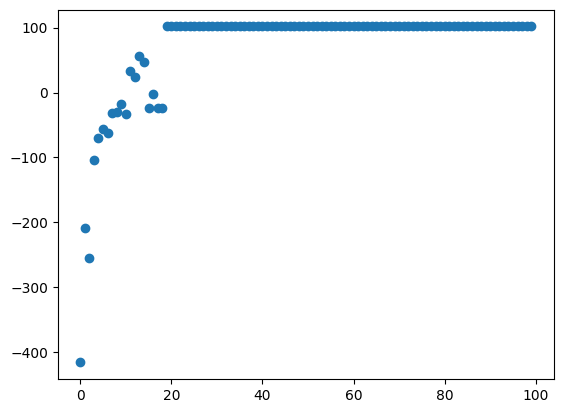

In [ ]:
# Individuum definieren
# Ihr Code 

print(schedule)
print_schedule(schedule)

def clac_unfairness(scores_by_study_program):
    vals = list(scores_by_study_program.values())
    var = np.var(vals)
    return var

def calc_fittnes(schedule,week_number,configuration):
    day_num = len(configuration['days'])
    room_num = 2
    slot_num = len(configuration['time_slots'])
    total_slots = day_num*room_num*slot_num

    programs_this_week = configuration['exam_weeks'][f'Week {week_number}']
    courses_per_program = configuration['study_programs']

    total_courses = 0
    for study_program in programs_this_week:
        total_courses += courses_per_program[study_program]
    
    proportional_slots = {}
    for study_program in programs_this_week:
        proportional_slots[study_program] = courses_per_program[study_program]/total_courses * total_slots
    
    all_values = []
    for day_slots in schedule.values():
        for slot in day_slots.values():
            all_values.extend(slot)

    count = Counter(all_values)
    actual_slots = dict(count)

    unproportional_slots_penalty = 0
    for study_program in actual_slots:
        unproportional_slots_penalty += np.abs(actual_slots[study_program]-proportional_slots[study_program])*10
    
    parallel_popularity_scores_by_study_program = {}
    consecutive_popularity_scores_by_study_program = {}
    day_popularity_scores_by_study_program = {}
    slot_popularity_scores_by_study_program = {}
    for study_program in programs_this_week:
        parallel_popularity_scores_by_study_program[study_program] = 0
        consecutive_popularity_scores_by_study_program[study_program] = 0
        day_popularity_scores_by_study_program[study_program] = 0
        slot_popularity_scores_by_study_program[study_program] = 0

    big_course_parallel_popularity = configuration['room_popularity']['parallel']
    for day in schedule:
        for slot in schedule[day]:
            parallel_rooms_by_study_program = Counter(schedule[day][slot])
            for study_program in dict(parallel_rooms_by_study_program):
                if courses_per_program[study_program] > 1 and parallel_rooms_by_study_program[study_program] > 1:
                    parallel_popularity_scores_by_study_program[study_program] += big_course_parallel_popularity

    course_consecutive_popularity = configuration['room_popularity']['sequential']
    for day in schedule:
        for i in range(1,len(schedule[day])):
            prev_key = list(schedule[day])[i-1]
            key = list(schedule[day])[i]
            prev_slot = schedule[day][prev_key]
            slot = schedule[day][key]
            for k in range(0,room_num):
                if(slot[k] in prev_slot):
                    consecutive_popularity_scores_by_study_program[slot[k]] += course_consecutive_popularity
    
    for day in schedule:
        for slot in schedule[day]:
            for study_program in schedule[day][slot]:
                day_popularity = configuration['days'][day]['popularity']
                slot_popularity = configuration['time_slots'][slot]['popularity']
                day_popularity_scores_by_study_program[study_program] += day_popularity
                slot_popularity_scores_by_study_program[study_program] += slot_popularity


    for study_program in courses_per_program:
        parallel_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        consecutive_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        day_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]
        slot_popularity_scores_by_study_program[study_program] /= courses_per_program[study_program]

    # delete score for study_programs with only one course, so the unfairnes score is not negativly impacted
    for study_program in programs_this_week:
        if courses_per_program[study_program] <= 1:
            del parallel_popularity_scores_by_study_program[study_program]

    # print(parallel_popularity_scores_by_study_program)
    # print(consecutive_popularity_scores_by_study_program)
    # print(day_popularity_scores_by_study_program)
    # print(slot_popularity_scores_by_study_program)
    
    unfairness_parallel_popularity_scores = clac_unfairness(parallel_popularity_scores_by_study_program)
    unfairness_consecutive_popularity_scores = clac_unfairness(consecutive_popularity_scores_by_study_program)
    unfairness_day_popularity_scores = clac_unfairness(day_popularity_scores_by_study_program)
    unfairness_slot_popularity_scores = clac_unfairness(slot_popularity_scores_by_study_program)

    # print(unfairness_parallel_popularity_scores)
    # print(unfairness_consecutive_popularity_scores)
    # print(unfairness_day_popularity_scores)
    # print(unfairness_slot_popularity_scores)


    parallel_popularity_score_total = sum(list(parallel_popularity_scores_by_study_program.values()))
    consecutive_popularity_score_total = sum(list(consecutive_popularity_scores_by_study_program.values()))
    day_popularity_score_total = sum(list(day_popularity_scores_by_study_program.values()))
    slot_popularity_score_total = sum(list(slot_popularity_scores_by_study_program.values()))

    total_score     =   parallel_popularity_score_total \
                    +   consecutive_popularity_score_total \
                    +   day_popularity_score_total \
                    +   slot_popularity_score_total \
                    -   unfairness_parallel_popularity_scores \
                    -   unfairness_consecutive_popularity_scores \
                    -   unfairness_day_popularity_scores \
                    -   unfairness_slot_popularity_scores \
                    -   unproportional_slots_penalty
    #TODO:          -   PENALTY_FOR_LATE_EARY_SLOTS
    #TODO:          -   PENALTY_FOR_NOT_A_SLOT_EVERY_DAY
    # print(total_score)
    return total_score

# print(schedule)



def mutate_schedule(schedule, mutation_probability=0.2):
    room_num = 2
    new_schedule = deepcopy(schedule)
    all_positions = [
        (day, slot, room)
        for day in new_schedule
        for slot in new_schedule[day]
        for room in range(room_num)
    ]

    if random.random() < mutation_probability:
        pos1, pos2 = random.sample(all_positions, 2)

        d1, s1, r1 = pos1
        d2, s2, r2 = pos2

        # Swap
        new_schedule[d1][s1][r1], new_schedule[d2][s2][r2] = \
            new_schedule[d2][s2][r2], new_schedule[d1][s1][r1]

    return new_schedule

def crossover_schedules(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    days = list(parent1.keys())
    crossover_day = random.choice(days)

    # Austausch ab crossover_day
    switch = False
    for day in days:
        if day == crossover_day:
            switch = True
        if switch:
            child1[day], child2[day] = deepcopy(parent2[day]), deepcopy(parent1[day])

    return child1, child2

generations_range = range(0,100)
best_scores = []
popilation_size = 100
population = []
population_scores = []
week_number = 2  # Zum Beispiel die erste Prüfungswoche
for i in range(0,popilation_size):
    schedule = random_assign_timeslots(week_number, configuration)
    population.append(schedule)
    population_scores.append(calc_fittnes(schedule,week_number,configuration))



best_schedule = None
for i in generations_range:
    # Population nach Fitness sortieren
    sorted_population = [x for _, x in sorted(zip(population_scores, population), key=lambda pair: pair[0], reverse=True)]
    top_half = sorted_population[:popilation_size // 2]

    # Neue Population durch Crossover
    new_population = []
    while len(new_population) < popilation_size // 2:
        parent1, parent2 = random.sample(top_half, 2)
        child1, child2 = crossover_schedules(parent1, parent2)
        new_population.append(child1)
        if len(new_population) < popilation_size // 2:
            new_population.append(child2)

    # Neue Gesamtpopulation und zugehörige Fitness
    population = top_half + new_population
    population_scores = [calc_fittnes(ind, week_number, configuration) for ind in population]

    best_scores.append(min(population_scores))
    best_schedule = sorted_population[0]


plt.scatter(generations_range,best_scores)
plt.show()

print(best_schedule)

#### Erläuterung / Begründung zur Modellierung von Individuen

<...Ihr Text ...>

In [ ]:
# Fitnessfunktion definieren
# Ihr Code



#### Erläuterung / Begründung zur Fitnessfunktion

<...Ihr Text ...>

In [ ]:

# Modell ersetzen durch eigenes für diese Aufgabe

# Erstelle die Basisobjekte für DEAP

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 100)  # Erzeuge zufällige Integer zwischen 1 und 10
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_int, n=4)  # Erzeuge ein Individuum mit 4 Integern
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate) # Ihre zentrale Stelle ...

Ein Beispiel wie ausgewertet werden kann. Die Bewertung einer Verletzung der proportionalen Raumzuteilung ist mit -10 festgesetzt (nicht ändern).

In [ ]:
def count_slots(schedule):
    slot_count = {}
    
    for day, slots in schedule.items():
        for slot, rooms in slots.items():
            for program in rooms:
                if program not in slot_count:
                    slot_count[program] = 0
                slot_count[program] += 1
    
    return slot_count

def calculate_slot_allocation(week_number, configuration):
    study_programs = configuration['exam_weeks'].get(f"Week {week_number}", [])
    total_courses = sum(configuration['study_programs'][program] for program in study_programs)
    
    # Berechne die proportionalen Slots
    slot_allocation = {}
    for program in study_programs:
        num_courses = configuration['study_programs'][program]
        slot_allocation[program] = round((num_courses / total_courses) * 40)
    return slot_allocation
    
def evaluate_schedule(schedule, configuration):
    # Bewertung basierend auf der Popularität der Slots und Tage
    slot_popularity = configuration['time_slots']
    day_popularity = configuration['days']
    
    score = 0
    for day, slots in schedule.items():
        day_score = day_popularity[day]['popularity']
        for slot, rooms in slots.items():
            slot_score = slot_popularity[slot]['popularity']
            # Addiere die Beliebtheitswerte jedes belegten Slots
            if all(rooms):  # Nur wenn beide Slots belegt sind
                score += (day_score + slot_score)
    
    return score
# Zähle die Slots, die den Studiengängen zugewiesen wurden
slot_counts = count_slots(schedule)
print("Slot-Zuweisung pro Studiengang:", slot_counts)

# Berechne die proportionalen Slot-Zuteilungen
slot_allocations = calculate_slot_allocation(week_number, configuration)
print("Proportionale Slot-Zuteilung pro Studiengang:", slot_allocations)

# Bewertungsfunktion
schedule_score = evaluate_schedule(schedule, configuration)
print("Bewertung des Zeitplans:", schedule_score)

def calculate_differences_and_penalty(slot_counts, slot_allocations):
    differences = {}
    total_penalty = 0
    
    for program in slot_allocations:
        allocated_slots = slot_allocations.get(program, 0)
        counted_slots = slot_counts.get(program, 0)
        
        difference = counted_slots - allocated_slots
        differences[program] = difference
        
        # Berechne die Strafe basierend auf der Abweichung
        penalty = abs(difference) * -10
        total_penalty += penalty
    
    return differences, total_penalty
    
# Berechnungen durchführen
slot_counts = count_slots(schedule)
slot_allocations = calculate_slot_allocation(week_number, configuration)

# Abweichungen und Strafen berechnen
differences, total_penalty = calculate_differences_and_penalty(slot_counts, slot_allocations)

# Ausgabe
print("Abweichungen pro Studiengang:", differences)
print("Gesamtstrafen:", total_penalty)
print("Gesamtbewertung:", total_penalty+schedule_score)

In [ ]:
# Population wählen 

### Begründung zum Modell

<...Ihr Text...>

### 2. Test und Bewertung 

Testen Sie die Funktionsweise Ihres Modells und diskutieren Sie die Ergebnisse.

In [ ]:
# Ihr Code



### Diskussion der Ergebnisse 

<...Ihr Text...>

## Aufgabenteil 2: Constraint Satisfaction Problems

Entwerfen Sie ein KI Modell auf Basis von Constraints und setzen Sie dieses als
Jupyter Notebook um. Wählen Sie geeignete Constraints.

In [ ]:
from constraint import *
# from ortools.sat.python import cp_model    # Alternative Library (schneller)

### 1. Variablen bestimmen 

... und ihre Wertebereiche!

In [ ]:
# Beispiel - hier soll Ihr Code eingefügt werden


#Variablen definieren und Wertebereiche festlegen
csp.addVariable("A", [i for i in range(0,25+1)])
csp.addVariable("B", [i for i in range(0,100+1)])
csp.addVariable("C", [i for i in range(0,20+1)])
csp.addVariable("D", [i for i in range(0,10+1)])

# am Schluss kurz alle Kombinationen ausgeben (zur Kontrolle)

csp.getSolutions()

### Begründung zur Wahl der Variablen

<...Ihr Text...>

### 2. Constraints bestimmen

Hier liegt sicher die Hauptaufgabe. Zur Umsetzung als CSP ist ein geeigneter Fairnessrahmen als Grenzwert anzugeben (und als Constraint umzusetzen)

In [ ]:
# Beispiel aus dem Übungslabor - durch eigene Lösung zu ersetzen


def volumenlimit(a,b,c,d):
    return (a * 100 + b * 50 +c * 70 + d * 25 < 2500)
    
    
csp.addConstraint(volumenlimit, ["A","B","C","D"])
    
# Gewichtslimit 2800

def gewichtslimit(a,b,c,d):
    return (a * 120 + b * 175 +c * 140 + d * 100 < 2800)

csp.addConstraint(gewichtslimit, ["A","B","C","D"])

### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist die Lösung? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Constraint und Variablenwahl) und testen Sie geeignet. 

In [ ]:
# Ihr Code


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>